If you haven't seen one before, this is a Jupyter notebook. Jupyter is a system that lets us embed code snippets with text for educational purposes. The code in this file is broken into cells which can be executed independently. To run a cell, click on it and hit SHIFT + ENTER. To inspect the value of a variable, just write its name as the last line in the cell.

# Part I: Linearization

The first step of designing the LQR controller for our quadrotor is to linearize the system about the hover state. The equations for the 3D quadrotor, however, are complicated, and computing the necessary derivatives is too tedious to want to do by hand. Therefore, we will use a computer algebra system (CAS) to save us a lot of time in computing derivatives. Specifically, we will be using the [SymPy](https://docs.sympy.org/latest/index.html) package to help us along the way. If you have experience with Mathematica or MATLAB's Symbolic Toolkit, SymPy offers many of the same features but in a Python interface, and even allows us to convert the symbolic functions that we will derive into efficient numerical ones.

To get started, we will demonstrate how to use SymPy to symbolically linearize the planar quadrotor model, then leave it to you to linearize the 3D model. We also suggest looking through the [brief tutorial](https://docs.sympy.org/latest/tutorials/intro-tutorial/index.html#intro-tutorial) given in the SymPy documentation, which will cover most of what you will need for this assignment. Again, the dynamics of the planar quadrotor are:

$$\begin{align}\ddot{x} &= -\frac{u_1}{m}\sin\theta\\ \ddot{y} &= \frac{u_1}{m}\cos\theta - g\\ \ddot{\theta} &= \frac{u_2}{I}\end{align}$$

We begin by importing the functions we need from SymPy.

In [1]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

Next, we define the symbolic variables we need to describe the equations of motion. The function ``dynamicsymbols`` creates symbols that vary in time, i.e. ``dynamicsymbols('x')`` will create a symbol $x(t)$ as opposed to $x$.

In [2]:
m, g, I, r, t = sp.symbols('m g I r t')
u1, u2  = sp.symbols('u1 u2')
x, y, theta = dynamicsymbols('x y theta')

We also define some variables as shorthand for the time derivatives of our state variables.

In [3]:
x_dot = sp.diff(x, t)
y_dot = sp.diff(y, t)
theta_dot = sp.diff(theta, t)

Now, we write out the equations of motion. Note that `sp.Matrix` is used to create both matrices and vectors in a manner similar to `np.array`.

In [4]:
state = sp.Matrix([x, y, theta, x_dot, y_dot, theta_dot])
input = sp.Matrix([u1, u2])

dynamics = sp.Matrix([x_dot, y_dot, theta_dot,
                      -u1 / m * sp.sin(theta),
                      u1 / m * sp.cos(theta) - g,
                      u2 / I])

Finally, we differentiate and plug in numerical values via the `subs` method. In this case, the hover state is chosen to be the $0$ vector and the hover input is $u_1 = m g$. We'll leave the parameters of the system as symbolic values for now so we can see the structure of the result.

In [5]:
A = dynamics.jacobian(state)
B = dynamics.jacobian(input)

In [6]:
A.subs([(u1, m * g), (theta, 0)])

Matrix([
[0, 0,  0, 1, 0, 0],
[0, 0,  0, 0, 1, 0],
[0, 0,  0, 0, 0, 1],
[0, 0, -g, 0, 0, 0],
[0, 0,  0, 0, 0, 0],
[0, 0,  0, 0, 0, 0]])

In [7]:
B.subs([(theta, 0)])

Matrix([
[  0,   0],
[  0,   0],
[  0,   0],
[  0,   0],
[1/m,   0],
[  0, 1/I]])

The last thing we need to discuss is turning the A and B matrices in the previous cells into `np.ndarray` types. The reason we want to do this is that after we replace the remaining system parameters with numerical values, SymPy will represent these values in a way that is very precise, but incredibly inefficient for the numerical work we need to do. Instead, we want to work with NumPy's numerical arrays, i.e. `np.ndarray`. These cannot handle symbolic values like SymPy's matrices and will not operate at same level of precision, but they are much more efficient for computational purposes.

In [8]:
A_arr = np.array(A.subs([(u1, m * g), (theta, 0), (m, 0.03), (g, 9.81)])).astype(float)

B_arr = np.array(B.subs([(theta, 0), (m, 0.03), (I, 1.419e-5)])).astype(float)

In each of these two lines, we are doing the following. First, we substitute in all the hover state and parameter numerical values as before. Next, we call `np.array` to convert from `sp.Matrix` to `np.ndarray`. However, we still have to tell numpy which data type to use to represent the numerical values in this matrix. To do so, we call the method `np.ndarray.astype()` with the type we want, `float`. You can see these matrices have a different numerical representation now:

In [9]:
print(A_arr)
print()
print(B_arr)

[[ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.   -9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]]

[[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [3.33333333e+01 0.00000000e+00]
 [0.00000000e+00 7.04721635e+04]]


## Problem 1 (40 Pts)
Now it's your turn! In the following cells (you can add more as needed), please write the code to linearize the 3D quadrotor model that was discussed in class. You are free to use the full functionality of SymPy --- the [cross product](https://docs.sympy.org/latest/modules/matrices/matrices.html?highlight=cross#sympy.matrices.matrices.MatrixBase.cross) and [matrix inverse](https://docs.sympy.org/latest/modules/matrices/matrices.html?highlight=cross#sympy.matrices.matrices.MatrixBase.inv) methods will be particularly useful. The function should print $\mathbf{A}$ and $\mathbf{B}$ matrices computed like above as `np.ndarray` variables. Please place your answers in the variables `A_arr` and `B_arr`. As a reminder, the dynamics are given by

$$\begin{align}\ddot{\mathbf{r}} &= \begin{bmatrix}0\\0\\-g\end{bmatrix} + \mathbf{R} \begin{bmatrix}0\\0\\\frac{F_{tot}}{m}\end{bmatrix}\\ \dot{\omega}_{BW} &= \mathbf{I}^{-1} \left(-\omega_{BW} \times \mathbf{I} \omega_{BW} + \begin{bmatrix}M_1\\ M_2\\ M_3\end{bmatrix}\right)\end{align}$$

where $\mathbf{r}$ is the position in the world frame of the center of mass of the quadrotor, i.e.

$$\mathbf{r} = \begin{bmatrix}x\\ y\\ z\end{bmatrix}$$

the rotation matrix $\mathbf{R}$ maps from the body frame to the world frame following the Space 1-2-3 convention, that is

$$\mathbf{R} = \begin{bmatrix}\cos(\theta)\cos(\psi) & \sin(\phi)\sin(\theta)\cos(\psi) - \sin(\psi)\cos(\phi) & \cos(\phi)\sin(\theta)\cos(\psi) + \sin(\psi)\sin(\phi)\\
\cos(\theta)\sin(\psi) & \sin(\phi)\sin(\theta)\cos(\psi) + \cos(\psi)\cos(\phi) & \cos(\phi)\sin(\phi)\sin(\psi) - \cos(\theta)\sin(\phi)\\
-\sin(\theta) & \sin(\phi)\cos(\theta) & \cos(\phi)\cos(\theta)\end{bmatrix}$$

and 

$$\omega_{BW} = \begin{bmatrix}p\\ q\\ r\end{bmatrix}$$

is the angular velocity of the body frame in the world frame, which is related to the rate of change of the Euler angles by

$$\begin{bmatrix}\dot{\phi}\\ \dot{\theta}\\ \dot{\psi}\end{bmatrix} = \begin{bmatrix}1 & \sin(\phi)\tan(\theta) & \cos(\phi)\tan(\theta)\\
         0 & \cos(\phi) & -\sin(\phi)\\
         0 & \frac{\sin(\phi)}{\cos(\theta)} & \frac{\cos(\phi)}{\cos(\theta)}
        \end{bmatrix}\begin{bmatrix}p\\ q\\ r\end{bmatrix}$$

In addition to the hover state and input, you should substitute the following values for the physical parameters of the system:

- $m = 0.03kg$
- $g = 9.81 \frac{m}{s^2}$
- $I_{xx} = 1.4194e-05$
- $I_{yy} = 1.4089e-05$
- $I_{zz} = 2.9741e-05$

Note the full state of the system $\mathbf{x}$ and system inputs $\mathbf{u}$ are the variables, in order,

$$\begin{align}\mathbf{x} = \begin{bmatrix}x\\ y\\ z\\ \phi\\ \theta\\ \psi\\ \dot{x}\\ \dot{y}\\ \dot{z}\\ p\\ q\\ r\end{bmatrix} & & \mathbf{u} = \begin{bmatrix}F_{tot}\\ M_1\\ M_2\\ M_3\end{bmatrix}\end{align}$$

and the hover state for this system that we are linearizing about is:

$$\begin{align}\mathbf{x} = \mathbf{0} & & \mathbf{u} = \begin{bmatrix}mg\\ 0\\ 0\\ 0\end{bmatrix}\end{align}$$

In [10]:
m, g, I, t = sp.symbols('m g I t')
F_tot, M1, M2, M3  = sp.symbols('F_tot M1 M2 M3')
x, y, z, phi, theta, psi, p, q, r = dynamicsymbols('x y z phi theta psi p q r')

In [11]:
x_dot = sp.diff(x, t)
y_dot = sp.diff(y, t)
z_dot = sp.diff(z, t)

In [12]:
state = sp.Matrix([x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, p, q, r])
input = sp.Matrix([F_tot, M1, M2, M3])

In [13]:
S = sp.Matrix([[1, sp.sin(phi) * sp.tan(theta), sp.cos(phi) * sp.tan(theta)],
               [0, sp.cos(phi), -sp.sin(phi)],
               [0, sp.sin(phi) / sp.cos(theta), sp.cos(phi) / sp.cos(theta)]]) * \
    sp.Matrix([p, q, r])

phi_dot = S.row(0)
theta_dot = S.row(1)
psi_dot = S.row(2)

In [14]:
R = sp.Matrix([[sp.cos(theta) * sp.cos(psi), sp.sin(phi) * sp.sin(theta) * sp.cos(psi) - sp.sin(psi) * sp.cos(phi), sp.cos(psi) * sp.sin(theta) * sp.cos(psi) + sp.sin(psi) * sp.sin(phi)],
               [sp.cos(theta) * sp.sin(psi), sp.sin(phi) * sp.sin(theta) * sp.cos(psi) + sp.cos(psi) * sp.cos(phi), sp.cos(phi) * sp.sin(phi) * sp.sin(psi) - sp.cos(theta) * sp.sin(phi)],
               [-sp.sin(theta), sp.sin(phi) * sp.cos(theta), sp.cos(phi) * sp.cos(theta)]])

r_2dot = sp.Matrix([0, 0, -g]) + R * sp.Matrix([0, 0, F_tot / m])

x_2dot = r_2dot.row(0)
y_2dot = r_2dot.row(1)
z_2dot = r_2dot.row(2)

In [15]:
I = sp.Matrix([[1.4194e-5, 0, 0],
               [0, 1.4089e-5, 0],
               [0, 0, 2.9741e-5]])
omega = sp.Matrix([p, q, r])

omega_dot = I.inv() * (-omega.cross(I * omega) + sp.Matrix([M1, M2, M3]))

p_dot = omega_dot.row(0)
q_dot = omega_dot.row(1)
r_dot = omega_dot.row(2)

In [16]:
dynamics = sp.Matrix([x_dot, y_dot, z_dot,
                      phi_dot, theta_dot, psi_dot,
                      x_2dot, y_2dot, z_2dot,
                      p_dot, q_dot, r_dot])

In [17]:
A = dynamics.jacobian(state)
B = dynamics.jacobian(input)

In [18]:
A_ = A.subs([(phi, 0),
             (theta, 0),
             (psi, 0),
             (p, 0),
             (q, 0),
             (r, 0),
             (F_tot, m * g),
             (m, 0.03),
             (g, 9.81)])

In [19]:
B_ = B.subs([(phi, 0),
             (theta, 0),
             (psi, 0),
             (m, 0.03)])

In [20]:
A_arr = np.array(A_)
B_arr = np.array(B_)

In [21]:
print(A_arr)
print()
print(B_arr)

[[0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 9.81000000000000 0 0 0 0 0 0 0]
 [0 0 0 -9.81000000000000 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [33.3333333333333 0 0 0]
 [0 70452.3037903339 0 0]
 [0 0 70977.3582227270 0]
 [0 0 0 33623.6172287415]]


Hopefully this example demonstrated the power of CAS tools for simplifying tedious calculations!

# Part II: Calculating Thrust Coefficient

In this part of the assignment, we will calculate the _thrust coefficient_ and _drag coefficient_ of the [Crazyflie](https://www.bitcraze.io/products/crazyflie-2-1/), which is the drone we are using in this course. As was mentioned in class, having a good characterization of these parameters is important for any controller derived from the system model to work well. We will estimate these parameters from data collected from a real Crazyflie in our lab as a warm up exercise for doing numerical computing in Python. The simple statistical tools we need will be explained as we go.

The force, $F_i$, and moment, $M_i$, produced by each motor is given by

$$\begin{align}F_i = k_f \omega_i^2 & & M_i = k_m \omega_i^2\end{align}$$

Here, $\omega_i$ is the rotational speed of the motor, $k_f$ is the thrust coefficient, and $k_m$ is the drag coefficient. The experimental procedure used to find $k_f$ is straightforward. Since $\omega_i^2$ is linearly related to $F_i$ and $\omega_i^2$ can be set to arbitrary values, we can simply measure the thrust produced at different values of $\omega_i$ and perform a _linear regression_, which is another name for calculating the line of best fit.

## Linear Regression Overview

Linear regression is a simple but useful statistical tool. This section will provide a quick overview of the technique in case you have not already seen it in a statistics or linear algebra class.

Consider the following scenario. We have a data set $\{(\mathbf{x}_i, y_i)\}_{i = 1}^N$, where $\mathbf{x}_i \in \mathbb{R}^n$ represents the input to some function and $y_i \in \mathbb{R}$ represents the measured output. We assume that the output is linearly related to the input and that there is some amount of additive random noise $e_i$ representing measurement error, i.e.

$$y_i = \mathbf{a}^{\top}\mathbf{x}_i + e_i$$

Our goal is to characterize the mapping between $\mathbf{x}$ and $\mathbf{y}$ by finding $\mathbf{a}$. To do so, we first recognize that we can write the $N$ constraints given by the previous equation as

$$\mathbf{y} = \mathbf{X}\mathbf{a} + \mathbf{e}$$

where

$$\begin{align}\mathbf{y} = \begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix} & & \mathbf{X} = \begin{bmatrix}\mathbf{x}_1^{\top}\\ \vdots \\ \mathbf{x}_N^{\top}\end{bmatrix} & & \mathbf{e} = \begin{bmatrix}e_1\\ \vdots \\ e_N\end{bmatrix}\end{align}$$.

If $\mathbf{e}$ is known, we could simply attempt to invert $\mathbf{X}$ to compute $\mathbf{a}$. However, since the measurement noise is rarely known, we cannot persue this avenue. Moreover, $\mathbf{X}$ is rarely square and / or of full rank. We often choose $N >> n$ in order to compensate for the fact that some of our measurments will have significant errors. So, instead, we will try to find a value for $\mathbf{a}$ that tries to get "as close as possible" to satisfying

$$\mathbf{y} = \mathbf{X}\mathbf{a}$$.

While there are a number of ways we can define "as close as possible" formally, the one that we are going to pick is the square of the $2$-norm of the difference between the left and right hand sides of the previous equation. This choice is made for a number of practical and analytic reasons that are beyond the scope of this class. This choice corresponds to the optimization problem

$$\underset{\mathbf{a}}{\mathrm{minimize}}\ \frac{1}{2}\|\mathbf{y} - \mathbf{X}\mathbf{a}\|_2^2$$

This kind of optimization problem is known as a _least-squares problem_ and is a kind of _unconstrained quadratic program_. The details of what that means are unimportant, but methods for solving these problems are very well-studied, and methods for doing so are already implemented as part of SciPy.

## Implementation

First, we are going to import the libraries and data that we need. Feel free to use any function in these libraries to help in the assignment.

In [22]:
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear

npzfile = np.load('quad_data/thrust_data.npz')
thrusts = npzfile['thrusts']
grams = npzfile['grams']

## Problem 2 (30 Pts)
You will use the `lsq_linear` function to solve the least-squares problem described above. It's documentation is available [here](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.lsq_linear.html).

First, we need to discuss an implementation detail. Internally, the Crazyflie doesn't work in terms of commanded angular velocities for the rotors but instead in terms of a percentage of the maximum angular velocity of which the rotors are capable. Moreover, this quantity is represented as a 16-bit integer, so values range from $0$ to $2^{16}$, with $0$ corresponding to $0$% angular velocity and $2^{16}$ corresponding to $100$% angular velocity. Therefore, for the purposes of writing a controller, we are really interested in measuring the value of $k_f$ for the equation

$$F_{tot} = k_f \sum_{i = 1}^4\tilde{\omega}_i^2$$

where $\tilde{\omega}^2_i$ is the percentage of max. angular velocity represented as a 16-bit integer in the manner just described for the $i$th rotor and $F_{tot}$ is the total thrust in _newtons_.

To collect data, we measured the thrust of the quadrotor on a scale while sweeping $\tilde{\omega}_i^2$ through a series of values three different times. The data from this experimented was just imported in the following format:
- `thrusts`: An `np.ndarray` containing $M$ different percentages of max. thrust to which the rotors were set for data collection _in grams_. You will need to rescale this to the 16-bit integer representation by multiplying by $2^{16}$. _All four rotors were set to this value at the same time_.
- `grams`: An `np.ndarray` of dimension $M$-by-$3$. The value in entry `grams[i, j]` corresponds to the value the scale measured, in grams, when all four motors were set to the percentage of total thrust given in `thrusts[i]` on the `j`th experimental trial. You will need to convert these to Newtons.

Your assignment, is to, in the next cell, compute $k_f$ by finding the best-fit line for this data. It's been found in the literature that, for this model of quadrotor, that

$$\frac{k_f}{k_m} \approx 40.7333$$

Therefore, you should also compute $k_m$ once you find $k_f$. Please put these values in the variables `k_f` and `k_m` respectively.

In [33]:
thrusts_scaled = 4 * thrusts * 2**16
thrusts_scaled = thrusts_scaled.repeat(3).reshape((3*len(thrusts_scaled), 1))
thrusts_scaled

array([[     0.],
       [     0.],
       [     0.],
       [ 16384.],
       [ 16384.],
       [ 16384.],
       [ 32768.],
       [ 32768.],
       [ 32768.],
       [ 49152.],
       [ 49152.],
       [ 49152.],
       [ 65536.],
       [ 65536.],
       [ 65536.],
       [ 81920.],
       [ 81920.],
       [ 81920.],
       [ 98304.],
       [ 98304.],
       [ 98304.],
       [114688.],
       [114688.],
       [114688.],
       [131072.],
       [131072.],
       [131072.],
       [147456.],
       [147456.],
       [147456.],
       [163840.],
       [163840.],
       [163840.],
       [180224.],
       [180224.],
       [180224.],
       [196608.],
       [196608.],
       [196608.],
       [212992.],
       [212992.],
       [212992.]])

In [32]:
newtons = grams / 1000 * 9.81
newtons = newtons.flatten()
newtons

array([0.      , 0.      , 0.      , 0.013734, 0.013734, 0.015696,
       0.041202, 0.041202, 0.043164, 0.069651, 0.071613, 0.071613,
       0.100062, 0.0981  , 0.100062, 0.130473, 0.130473, 0.131454,
       0.164808, 0.165789, 0.16677 , 0.198162, 0.1962  , 0.198162,
       0.233478, 0.233478, 0.229554, 0.262908, 0.263889, 0.267813,
       0.301167, 0.296262, 0.300186, 0.348255, 0.334521, 0.33354 ,
       0.375723, 0.368856, 0.368856, 0.413982, 0.40221 , 0.406134])

In [34]:
sol = lsq_linear(thrusts_scaled, newtons)

k_f = sol.x
k_m = k_f / 40.7333

Finally, run the following cell to check your work. It plots the data along with the best-fit line you found. If these don't line up (pun unintended), you will need to reevaluate your approach.

k_f = [1.82212053e-06]
k_m = [4.47329464e-08]


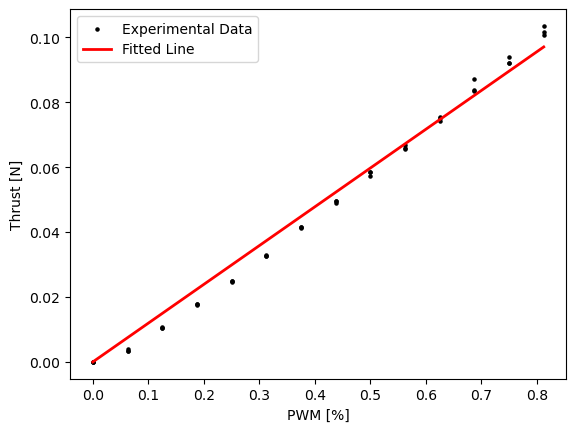

In [36]:
%matplotlib inline

for i in range(grams.shape[1]):
    if i == 0:
        plt.scatter(thrusts, 9.81 * grams[:, i] / 4000, c='k', s=5, label='Experimental Data')
    else:
        plt.scatter(thrusts, 9.81 * grams[:, i] / 4000, c='k', s=5)

plt.plot(thrusts, k_f * (2 ** 16) * thrusts, c='r', linewidth=2, label='Fitted Line')
plt.xlabel('PWM [%]')
plt.ylabel('Thrust [N]')
plt.legend()

print(f'k_f = {k_f}\nk_m = {k_m}')

# Submission Instructions

Please submit your completed Lab1.ipynb file to Gradescope "HW1: Coding". 

Also, please don't forget to turn in your solution to the written portion of the assignment to Gradescope "HW1: Theory".